In [1]:
import pandas as pd
import missingno as msno
from pandas.api.types import is_numeric_dtype
import os

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


In [2]:
#Load file
patient_excel = pd.ExcelFile("patients.xlsx")
df =patient_excel.parse("patient")
df.head(5)

Patient Nb State Patient Nb Date Announced Estimated Onset Date  \
0         1.0         KL-TS-P1     30/01/2020  2020-01-26 00:00:00   
1         2.0         KL-AL-P1     02/02/2020           29/01/2020   
2         3.0         KL-KS-P1     03/02/2020                  NaN   
3         4.0            DL-P1     02/03/2020                  NaN   
4         5.0            TS-P1     02/03/2020                  NaN   

  Age Bracket    G             Detected City Detected District Detected State  \
0          20    F                  Thrissur          Thrissur         Kerala   
1         NaN  NaN                 Alappuzha         Alappuzha         Kerala   
2         NaN  NaN                 Kasaragod         Kasaragod         Kerala   
3          45    M  East Delhi (Mayur Vihar)        East Delhi          Delhi   
4          24    M                 Hyderabad         Hyderabad      Telangana   

  State code Current Status  \
0         KL      Recovered   
1         KL      Recovered   
2         KL      Recovered   
3         DL      Recovered   
4         TG      Recovered   

                                               Notes  \
0                               Travelled from Wuhan   
1                               Travelled from Wuhan   
2                               Travelled from Wuhan   
3                      Travelled from Austria, Italy   
4  Travelled from Dubai to Bangalore on 20th Feb,...   

  Contracted from which Patient (Suspected) Nationality Type of trans  \
0                                       NaN       India      Imported   
1                                       NaN       India      Imported   
2                                       NaN       India      Imported   
3                                       NaN       India      Imported   
4                                       NaN       India      Imported   

  Status Change Date                                Backup Notes  Num Cases  \
0         14/02/2020                          Student from Wuhan        1.0   
1         14/02/2020                          Student from Wuhan        1.0   
2         14/02/2020                          Student from Wuhan        1.0   
3         15/03/2020         Travel history to Italy and Austria        1.0   
4         02/03/2020  Travel history to Dubai, Singapore contact        1.0   

   Entry_ID  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

<AxesSubplot:>

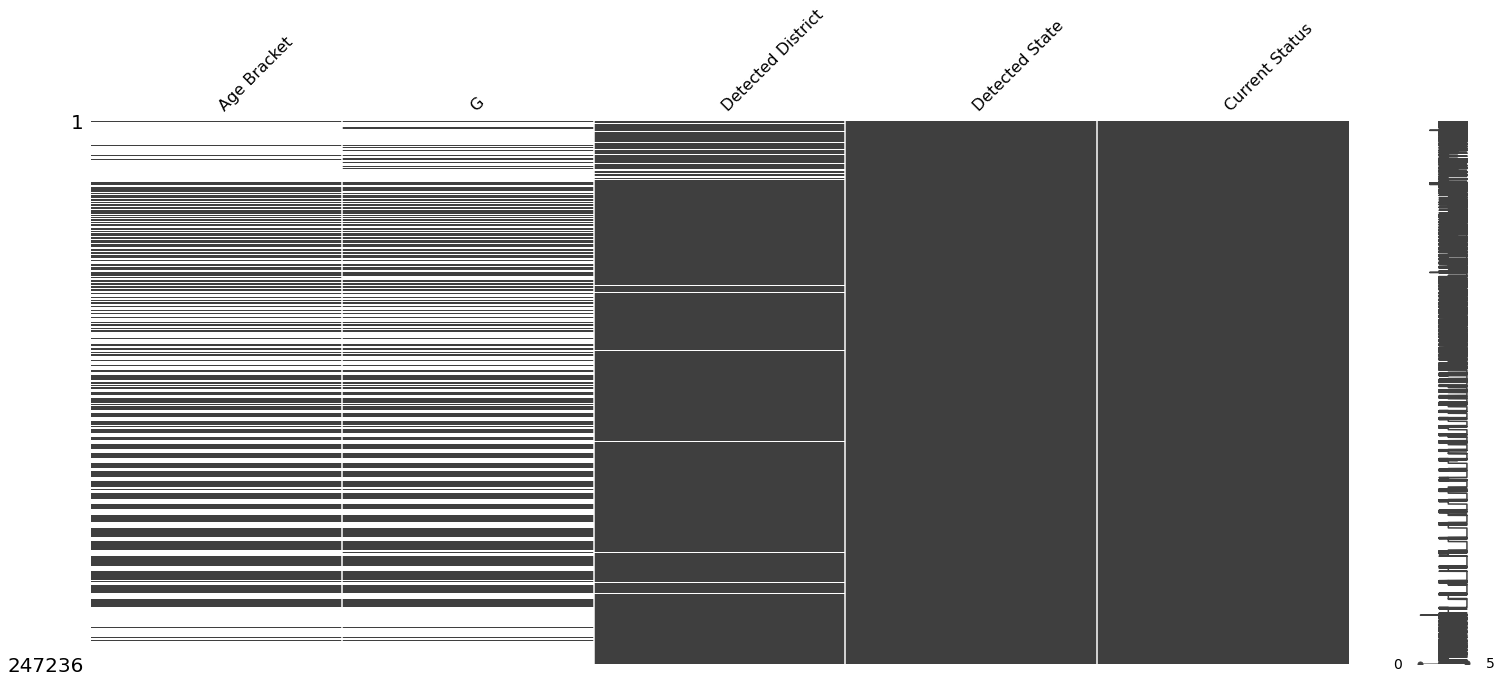

In [3]:
#Filter columns
target_columns = [
    "Age Bracket","G","Detected District","Detected State","Current Status"
]
df = df[df.columns[df.columns.isin(target_columns)]]
msno.matrix(df)

<AxesSubplot:>

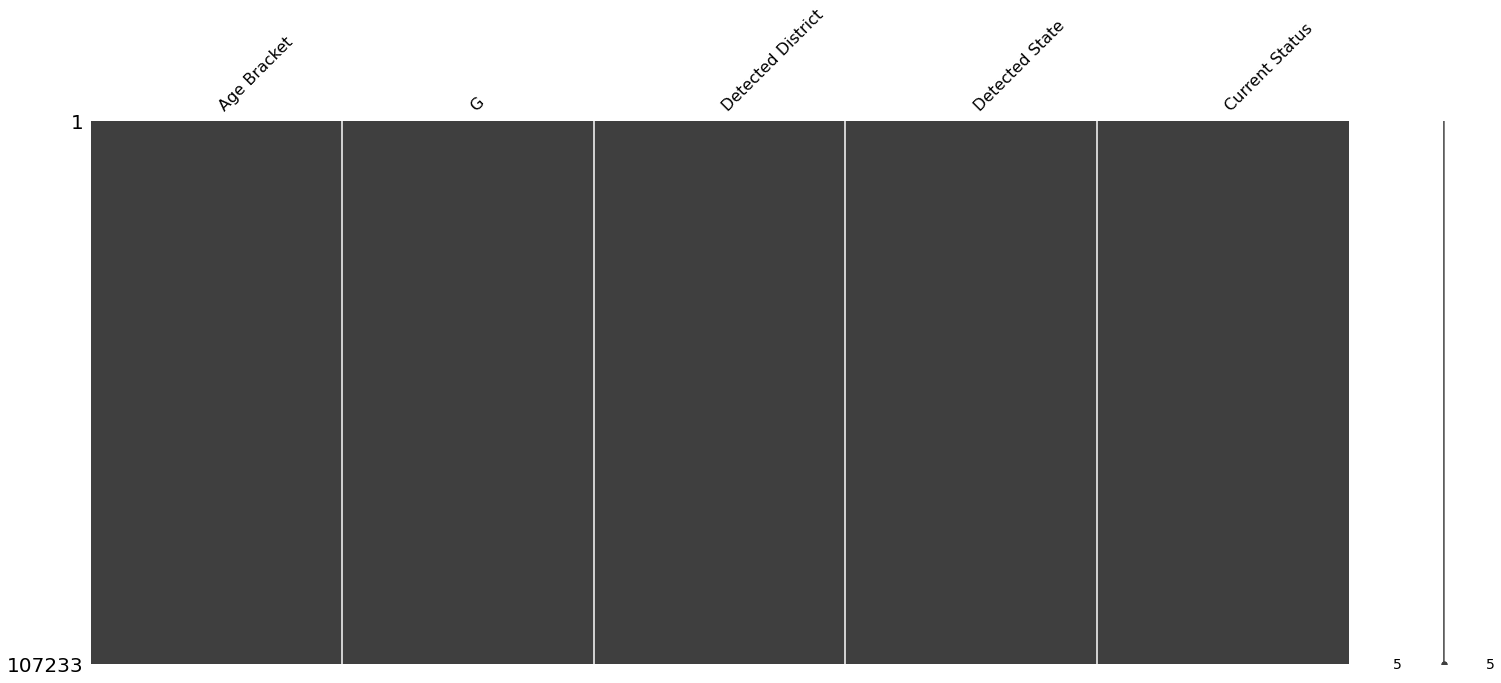

In [4]:
#Drop missing data
df.dropna(axis=0, how='any', inplace=True)
msno.matrix(df)

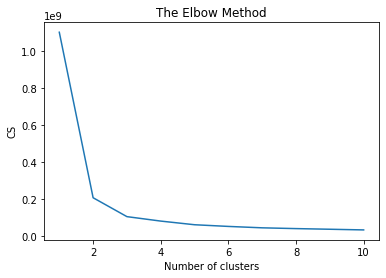

In [5]:
for col in df.columns:
    df = df.astype({col: str}, errors='raise')
#Encoding Labels (because type is object)
le = LabelEncoder()
for var in target_columns:
    df[var+str("_enc")] = le.fit_transform(df[var])
filter_col = [col for col in df if col.endswith('_enc')]
df_kmeans = df[df.columns[df.columns.isin(filter_col)]]
#The elbow method
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_kmeans)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [6]:
#k-means algorithme
kmeans = KMeans(n_clusters=4,random_state=0)

kmeans.fit(df_kmeans)

labels = kmeans.labels_
result = pd.DataFrame(labels , index=df["Detected State"], columns=["group"])
result["State"]  = result.index
result.reset_index(drop=True, inplace=True)
result.sample(5)

group       State
92431      3   Karnataka
33298      1   Karnataka
95500      0   Karnataka
55616      3   Karnataka
23577      0  Tamil Nadu

In [8]:
#Visualization
fig = px.choropleth(
    result,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='State',
    color='group',
    color_continuous_scale='Reds'
)

fig.show()